# Exercises 7: Molecular Dynamics in the canonical NVT

The purpose of the following exercises is to explore the thermodynamical properties and their behaviour in the Molecular Dynamics of a canical ensemble. The exercise background is very similar to the one we studied in Exercises 4 for the Molecular Dynamics in a microcanonical NVE, but this time the implementation of the <i>Move()</i> function is different: since we are now in a system where the energy is free to vary, we will now use the Metropolis algorithm instead of the Verlet one, which is a proper choice in systems where the energy is constant.

## <span style="color:navy">7.1) Autocorrelation and statistical errors</span>

In this first exercise we are asked to use the given NVT code in order to:
1. Print out instantaneous values of potential energy per particle, $U/N$, and pressure, $P$ in the following thermodynamic conditions:
    - solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
    - liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
    - gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)
   
   
2. Compute the autocorrelation function of $U/N$ and $P$ and fit it with an exponential function in order to obtain the Monte Carlo correlation time $t_c$.

3. Study the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. 

### Instantaneous values of $U/N$ and $P$
In order to evaluate the two thermodynamic properties, we firstly need to **equilibrate** the system. We can notice that it is different (and less demanding) compared to the NVE system, because now we do not need to rescale velocities for the Verlet algorithm, we just need to run the Metropolis algorithm a certain number of MC time steps to reach stable output results, but we can add simply a function <i> Equilibrate()</i> in the code – as we did in the Exercise 5 and 6 – and we do not need to re-run the program multiple times.

In order to obtain a Metropolis acceptance rate $\approx 50 \%$, I manually set the MC step:

- $ \delta_{solid} = 0.1 $

- $ \delta_{liquid} = 0.2 $

- $ \delta_{gas} = 7.5 $

Against what I did in Exercise 4, I now prefer not to change the original code, but I'd rather manage the phase input files thanks to a Python script.

**Note**: An improvement in the NVT code concerns the <i> tail correction </i>, added in order to reduce the error due to concedering just the particles within $r_c$:

$$ \frac{V_{tail}}{N}=\frac{8}{3} \pi \rho \epsilon \sigma^3 \left[ \frac{1}{3} \left(\frac{\sigma}{r_c} \right)^9 - \left(\frac{\sigma}{r_c} \right)^3 \right] $$

$$ \frac{W_{tail}}{3\epsilon N}=\frac{16}{3} \pi \rho \epsilon \sigma^3 \left[ \frac{2}{3} \left(\frac{\sigma}{r_c} \right)^9 - \left(\frac{\sigma}{r_c} \right)^3 \right] $$

which are evaluted in LJ units (rescaling units with $\sigma=\epsilon=1$).

In [5]:
############### RUN THE PROGRAM FOR EACH PHASE #######################################
##%%time

import os
phases=['solid','liquid','gas']

for p in phases:
    os.system("bash clean.sh")
    os.system("rm "+p+"/output.*") #delete previous file
    os.system("cp "+p+"/input."+p+" input.dat") #crate the proper input.dat
    os.system("./Monte_Carlo_NVT.exe") # run the executable
    os.system("mv output.* "+p) #move results into the proper forlder
    print (p+" finished ")

solid finished 
liquid finished 
gas finished 


In [129]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

phases=['solid','liquid','gas']
colors=['darkgreen', 'forestgreen', 'limegreen', 'darkmagenta', 'darkorchid', 'mediumslateblue']
titles=['Potential energy', 'Pressure']
axis=['U*/N', 'P*']
output=['epot','pres']

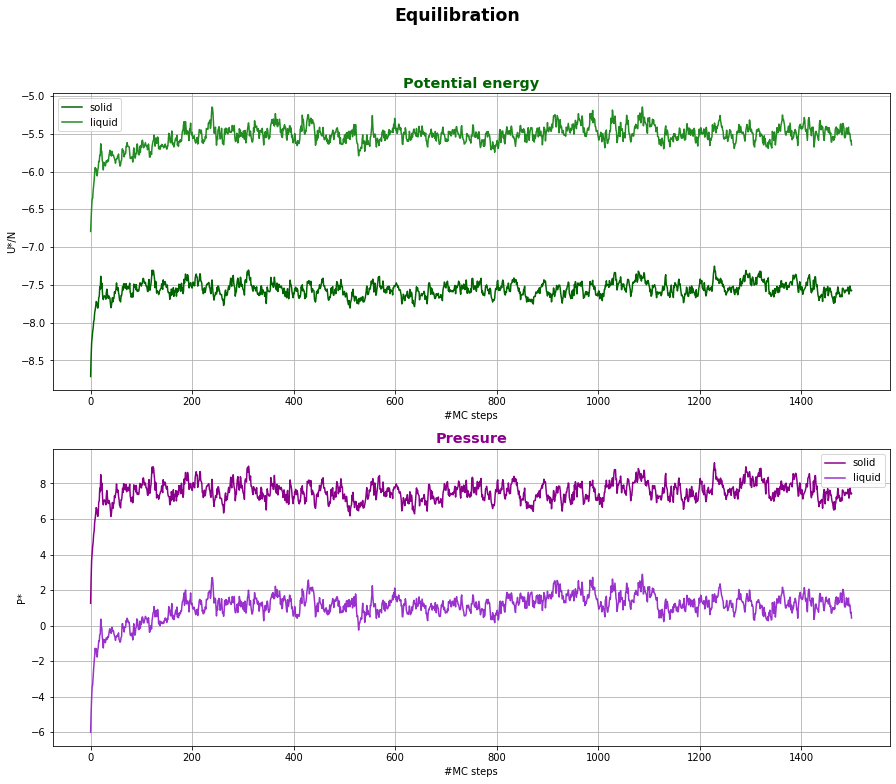

In [130]:
################## EQUILIBRATION ###############################################
fig=plt.figure(figsize=(15, 12))
plt.suptitle("Equilibration", size='xx-large', weight='bold')

for a in range(2):
    plt.subplot(2,1,a+1)
    for i in range(2):
        y = np.loadtxt("Equilibration/"+phases[i]+"/output."+output[a]+".instant", max_rows=1500)
        plt.plot(y, color=colors[a*3+i], label=phases[i])
        
    plt.xlabel('#MC steps')
    plt.ylabel(axis[a])
    plt.title(titles[a], color=colors[a*3], size='x-large', weight='bold')
    plt.grid(True)
    plt.legend()
plt.show()

Here up an example of equilibration, where just liquid and solid phases are plotted in order to better focus on small changes (the gas values are plotted much upper). We can see that after $\approx 200$ steps the system reaches the stability. In order to be sure to reach the equilibrium, I set $N_{equi}=300$. 

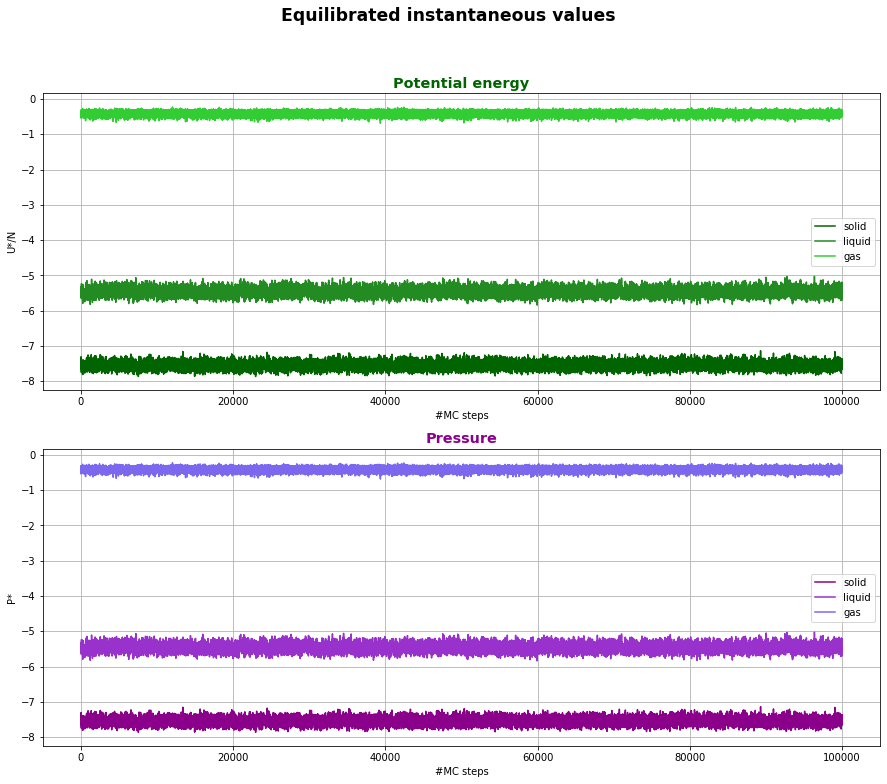

In [131]:
################## INSTANTANEOUS VALUES ###############################################
fig=plt.figure(figsize=(15, 12))
plt.suptitle("Equilibrated instantaneous values", size='xx-large', weight='bold')

for a in range(2):
    plt.subplot(2,1,a+1)
    for i in range(3):
        y = np.loadtxt("Instant/"+phases[i]+"/output.epot.instant")
        plt.plot(y, color=colors[a*3+i], label=phases[i])
        
    plt.xlabel('#MC steps')
    plt.ylabel(axis[a])
    plt.title(titles[a], color=colors[a*3], size='x-large', weight='bold')
    plt.grid(True)
    plt.legend()

plt.show()

### Autocorrelation function
Since the Metropolis algorithm shows high correlation among data it is very important to take actions that aim to avoid that final results are affected by this limit. 

This is why we basically need to measure the <i><span style="color:purple"> correlation MC-time $t_c$</span></i> : it is the MC-time interval (i.e. MC-steps) $t_c=t_f-t_i$ in which we can reach no correlation between the first observable measurement $x(t_i$) and the final one $x(t_f)$.

In order to evaluate $t_c$ we need the <i><span style="color:navy">autocorrelation function $\chi (t)$</span></i> , defined as follows:
    
$$ \chi(t)=\frac{\langle \ x(\ \bar{t} \ ) \cdot x(\ \bar{t}+t \ ) \ \rangle -\langle x( \ \bar{t} \ ) \rangle \cdot \langle x( \ \bar{t}+ t \ ) \rangle }{\sigma_ x^2}$$

where $t= \Delta t$ is the MC time between two consecutive measurements $x(t_i)=x( \ \bar{t} \ )$ and $x(t_f)=x(t_i +\Delta t) = x(\ \bar{t}+t)$.
It is easy to understand that when there is high correlation between the two measurements, $\chi(t)$ is large and positive, whereas it tends to zero when the two measurements are evaluated at two times long away apart. So we expect an exponential behaviour: 
$$\chi (t) \approx e ^{- \frac{t}{t_c}}$$

In this way we are provided of a method to evaluate $t_c$. Of course if $t=t_c$ the autocorrelation is decreased of a factor ($e^{-1}$), but it is not so close to zero; so it is conventionally chosen as a proper MC step $t=2 \ t_c$.

The fit function is: f(t)=exp(-t/t_c) with
Potential energy – solid: t_c= 8.03195148669634
Potential energy – liquid: t_c= 9.242806471734653
Potential energy – gas: t_c= 2.3022055355257733
Pressure – solid: t_c= 7.893855882431971
Pressure – liquid: t_c= 12.194717161207898
Pressure – gas: t_c= 0.88496013596585


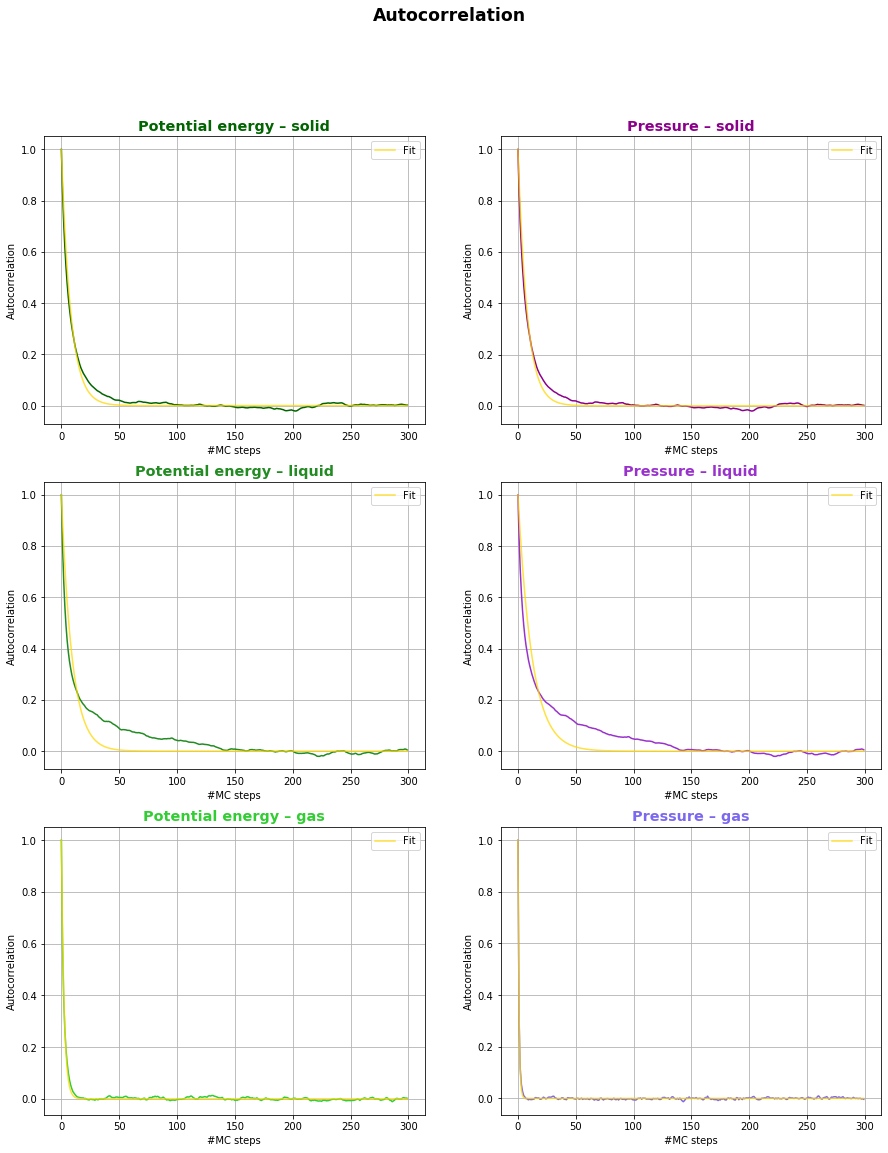

In [134]:
####################### AUTOCORRELATION #################################
from scipy.optimize import curve_fit
def f(x, t_c):
    return  np.exp(-x/t_c)

def autocorrelation(x, steps):
    autoc=np.zeros(steps)
    sigma=np.std(x)
    t_max=len(x)
    
    for dt in range(steps):
        n1=0.0
        n2=0.0
        n3=0.0
        #norm=0.0
        t_tot=t_max-dt
        for t in range(t_tot):
            n1+=x[t]*x[t+dt]
            n2+=x[t]
            n3+=x[t+dt]
            #n+=1.0
        autoc[dt]=(n1/t_tot-n2*n3/t_tot/t_tot)/sigma/sigma
    return autoc


fig=plt.figure(figsize=(15, 18))
plt.suptitle("Autocorrelation", size='xx-large', weight='bold')

print('The fit function is: f(t)=exp(-t/t_c) with')
t_steps=300
for a in range(2):
    for i in range(3):
        plt.subplot(3,2,i*2+1+a)
        y = np.loadtxt("Instant/"+phases[i]+"/output."+output[a]+".instant")
        auto=autocorrelation(y,t_steps)
        plt.plot(auto, color=colors[a*3+i])
        #fitting
        x=np.arange(t_steps)
        popt, pcov = curve_fit(f, x, auto)
        plt.plot(x, f(x, *popt), label="Fit", color='gold', alpha=0.75)
        plt.ylabel("Autocorrelation")
        plt.xlabel('#MC steps')
        plt.title(titles[a]+" – "+phases[i], color=colors[i+a*3], size='x-large', weight='bold')
        plt.grid(True)
        plt.legend()
        print(titles[a]+" – "+phases[i]+': t_c=',popt[0])
plt.show()

So we can then conclude that each couple of measurements with time step distance $\approx 2 \ t_c$ are little correlated and a proper size of blocks has the only condition to be greater of this value:

- Solid: $ \ \ \ \Delta t \gtrsim 16$

- Liquid: $ \ \Delta t \gtrsim 25$

- Gas: $ \ \ \ \  \Delta t \gtrsim 5$

### Statistical error
We are now going to estimate the error as the standard deviation of the mean, when considering different size of the blocks $L$:
$$\sigma =\sqrt{\frac{\langle x^2 \rangle - \langle x \rangle ^2}{N-1}}$$
where $N=M/L$, $M=10^5$ and $L \in [10 \ , \ 5\cdot10^3]$.

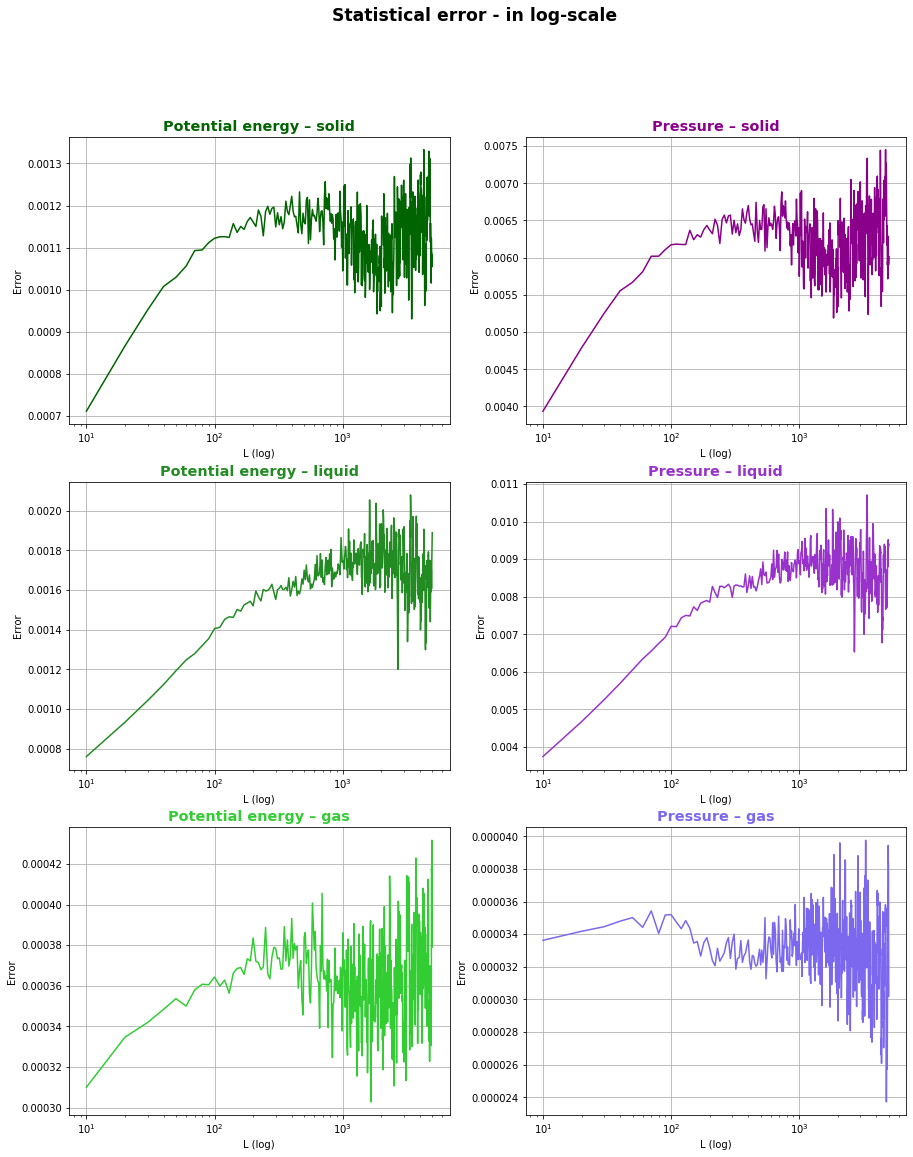

In [139]:
######################### STATISTICAL ERROR ###################################
def Error(ave, ave2, n):
    if(n==0): 
        return 0.0
    else: 
        return np.sqrt((ave2-ave**2)/n)

def data_blocking(x, N, L):
    mean=0.0
    mean2=0.0
    error=0.0
    for n in range(N):
        mean_block=0.0
        mean2_block=0.0
        for l in range(L):
            mean_block+=x[l+n*L]
        mean_block/=L
        mean=(mean*n+mean_block)/(n+1)
        mean2=(mean2*n+mean_block**2)/(n+1)
        error=Error(mean, mean2,n)
    return mean, error #lascio mean per completezza

L_m=10
L_M=5000
M=100000
L_step=10
L_steps=int((L_M-L_m)/L_step)

fig=plt.figure(figsize=(15, 18))
plt.suptitle("Statistical error - in log-scale", size='xx-large', weight='bold')

for a in range(2):
    for i in range(3):
        plt.subplot(3,2,i*2+1+a)
        y = np.loadtxt("Instant/"+phases[i]+"/output."+output[a]+".instant")
        error=[]
        x=[]
        for l in range(L_steps):
            L=L_m+l*L_step
            N=int(M/L)
            mean, err=data_blocking(y,N,L)
            error.append(err)
            x.append(L)
        plt.plot(x, error, color=colors[a*3+i])
        
        plt.ylabel("Error")
        plt.xlabel('L (log)')
        plt.xscale("log")
        plt.title(titles[a]+" – "+phases[i], color=colors[i+a*3], size='x-large', weight='bold')
        plt.grid(True)
        
plt.show()

We notice that there is a first interval where the error increases monotonically with the block size, while for $L \gtrsim 200$ a stationary behaviour is shown. This is another useful indication for choosing a proper value of $L$. In order to have uncorrelated indipendent variables $\{x_n\}_{n=1...N}$ and to apply the <i> Central Limit Theorem</i>, we should find that decreasing the number of blocks $N$ (i.e. increasing the size of each block $L$) after at a certain value would not lead to increase in error bar width as well. This is the threshold value we are looking for.
So we can consider a proper choice of $L$:
- Solid: $ \ \ \ L \gtrsim 300$

- Liquid: $ \ L \gtrsim 500$

- Gas: $ \ \ \ \  L \gtrsim 200$

**Note:** I added an option in the input file: <font face="Courier">print_instant</font>, which can be activated whenever one needs to print instantaneous properties in an output file (<font face="Courier">print_instant=1</font>). This decision was taken for three reasons: 
- instantaneous values were needed for the first exercises in order to equilibrate the size of blocks but for now on we just need average values; 
- since the system is now equilibrated in terms of data blocking method, we can reduce the number of total steps $10^5 \rightarrow 10^4$ but re-running the program with <font face="Courier">print_instant=1</font> we could overwrite the instantaneous data that we used to calibrate the block size; this is why I created a new folder, called <font face="Courier">"Instant"</font>, where you will find the data used in the previous exercises; 
- each "<font face="Courier">*.instant</font>" file is very expensive in terms of storage (for $10^5$ values, ~1 MB each file); this is why having already saved previous data it is better not to create new <i>heavy</i> files without needing them.

### <span style="color:darkmagenta"><i> –––––––– Rewrite input files and authomatically run the program for each phase ––––––––</i></span>

After this first phase of analysis and equilibration I needed to change the input files and re-run the program, I wrote these script to do it authomatically.

In [163]:
############### WRITE INPUT FILE #######################################
"""
import os

phases=['solid','liquid','gas']

temps=[0.8, 1.1,1.2]
npart=108
rhos=[1.1,0.8 ,0.05]
rcuts=[2.2,2.5,5.0]
deltas=[0.1,0.2,7.5]
nstep=15000 #=M
lstep=[500,500,500]
nblock=[]
for p in range(3):
    nblock.append(int(nstep/lstep[p]))
#nblock=50 #=N
#lstep=int(nstep/nblock) #=L
print_instant=0

for p in range(3):
    
    #prepare data in function of the phase:
    data=str(temps[p])+"\n"+str(npart)+"\n"+str(rhos[p])+"\n"+str(rcuts[p])+"\n"+str(deltas[p])+"\n"+str(nblock[p])+"\n"+str(lstep[p])+"\n"+str(print_instant)+"\n\n  ReadInput >> temp; \n  ReadInput >> npart; \n  ReadInput >> rho; \n  ReadInput >> rcut; \n  ReadInput >> delta; \n  ReadInput >> nblk; \n  ReadInput >> nstep; //=steps per block \n  ReadInput >> print_instant;"
    
    #change input.dat
    indat=open("input."+phases[p], "w+")
    indat.write(data)
    indat.close()
    os.system("mv input."+phases[p]+" "+phases[p])
    print("Created: input."+phases[p])
"""

Created: input.solid
Created: input.liquid
Created: input.gas


In [164]:
############### RUN THE PROGRAM FOR EACH PHASE #######################################
"""
%% time

import os
phases=['solid','liquid','gas']

for p in phases:
    os.system("rm "+p+"/output.*") #delete previous file
    os.system("cp "+p+"/input."+p+" input.dat") #crate the proper input.dat
    os.system("./Monte_Carlo_NVT.exe") # run the executable
    os.system("mv output.* "+p) #move results into the proper forlder
    print (p+" finished ")
"""

solid finished 
liquid finished 
gas finished 


In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

phases=['solid','liquid','gas']
colors=['darkgreen', 'forestgreen', 'limegreen', 'darkmagenta', 'darkorchid', 'mediumvioletred']
titles=['Potential energy', 'Pressure']
axis=['U*/N', 'P*']
output=['epot','pres']
colorsg=['crimson', 'orangered','orange']

### <span style="color:darkmagenta"> –––––––––– ~ • ~ –––––––––– ~ • ~ –––––––––– ~ • ~ –––––––––– ~ • ~ –––––––––– ~ • ~ ––––––––––</span>

## <span style="color:navy"> 7.2) Radial distribution function $g(r)$ </span>

The radial distribution function (or pair correlation function) $g(r)$ in a system of particles describes how density varies as a function of distance from a reference particle. In other words, if we consider a particle in the origin of the reference system, the density in function of the distance $r$ from that particle is $\rho(r)=\rho g(r)$, where $\rho=N/V$.


<div> <img src="g_r.png" width="350"/></div>

The analytical expression for the radial density is:

$$g(r)=\frac{1}{\rho N \Delta V (r)} \langle \sum_{i=1}^N \sum_{j =1, j\neq i}^N \delta \  ( \ r-|\vec r_i -\vec r_j| \ ) \ \rangle$$

where $\Delta V(r)=\frac{4\pi}{3}\left[(r+dr)^3-r^3\right]$ is the volume of the shell of thickness $dr$.

In order to implement this formula, we consider half of the box side $L_{box}$ divided into $n=100$ bins in order to obtain a descrete sequence of positions $r_0,r_1, \dots , r_n \ \in [0, L_{box}/2]$ with the bin size corresponding to the infinitesimal distance $dr$. Then we need to fill an histogram increasing the bin of $r_b$ by 2 (because it is reciprocal!) when two particles are found at distance between $r_b$ and $r_b+dr$. At the end we normalize the histogram with the quantity $\rho N \Delta V (r)$.

In order to have a feedback of the implementation, here is a graph of the $g(r)$ evaluated at the end of the <i>data blocking </i> process (<font face="Courier">output.gave.0</font>).

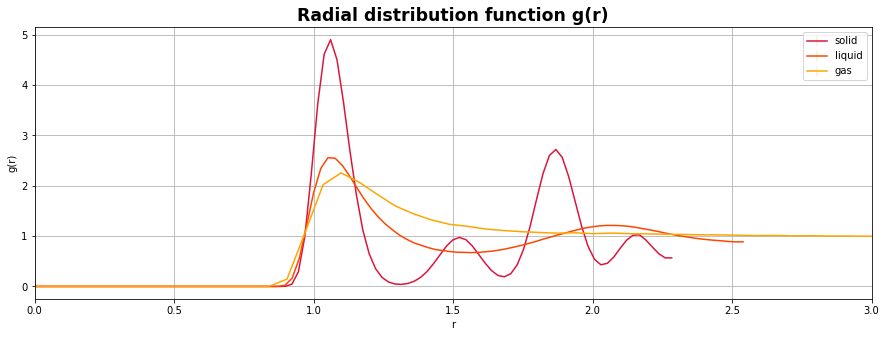

In [8]:
################## RDF g(r) ###############################################
fig=plt.figure(figsize=(15, 5))
plt.title("Radial distribution function g(r)", size='xx-large', weight='bold')

#NB: output has 0) iblock 1) r 2) block_mean 3) global_mean 4) error_global_mean
for i in range(3):
    x,y,err = np.loadtxt(phases[i]+"/output.gave.0", usecols=(1,3,4),unpack=True)
    plt.errorbar(x,y,yerr=err, color=colorsg[i], label=phases[i], ecolor='papayawhip')
        
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.xlim(0,3)
    plt.grid(True)
    plt.legend()

plt.show()

We can notice that all the three curves show a similar behaviour for $r \in [0,1]$:
1. $g(r)=0$ for $r \lesssim 1$ ( $r\lesssim \sigma$ in SI units ).
This indicates that there no possibility for two particles to overlap.
2. $g(r)=g_{max}$ for $r \approx 1$ ( $r\approx \sigma$ in SI units ).
This instead means that all particles tends to stay at distance $\sigma$ between each other.

But there are also differences in behaviours when the distance increases. The solid curve is much more compact and reaches highier values of g(r), showing several peaks. This is due to its cristalline structure that does not allow particles to move freely. This latter property is instead belonged to the gas phase, the curve smoothly embraches a larger interval of distances, showing that particles can be very spread in the space. Finally, we can notice a intermediate behaviour for the liquid phase, as we could expect.

## <span style="color:navy"> 7.3/7.4) RDF $g(r)$ – comparison with NVE code </span>

In this exercise we were asked to implement $g(r)$ also in the previous code we improved for the microcanical ensemble. In Exercise 4, I worked on two versions of the code: the first performs only in LJ units and through a single input file, while the second one was adapted for real experiments. For this exercise I considered the first one and, even though the two codes (NVE and NVT) were not exactly the same, I didn't need to change much to get the results of $g(r)$.

<span style="color:crimson">**Note**: in order to quickly equilibrate the system (in NVE code we need to run the program a few times) I created a Jupyter Notebook with a Python script that automatically manages input-output files and equilibrates the system. You just need to move in the folder "NVE" and run the Python script to get new results from the NVE code.</span>

Here is the comparison between the codes:

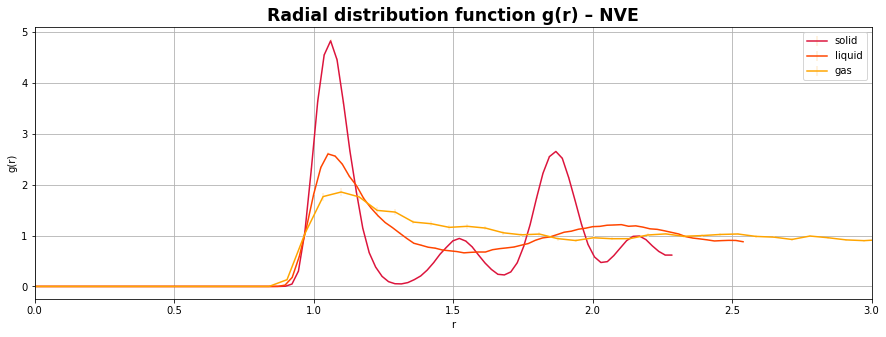

In [9]:
################## RDF g(r) ###############################################
fig=plt.figure(figsize=(15, 5))
plt.title("Radial distribution function g(r) – NVE", size='xx-large', weight='bold')

for i in range(3):
    x,y,err = np.loadtxt("NVE/"+phases[i]+"/ave_gave.out", usecols=(1,2,3),unpack=True)
    plt.errorbar(x,y,yerr=err, color=colorsg[i], label=phases[i], ecolor='papayawhip')
        
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.xlim(0,3)
    plt.grid(True)
    plt.legend()

plt.show()

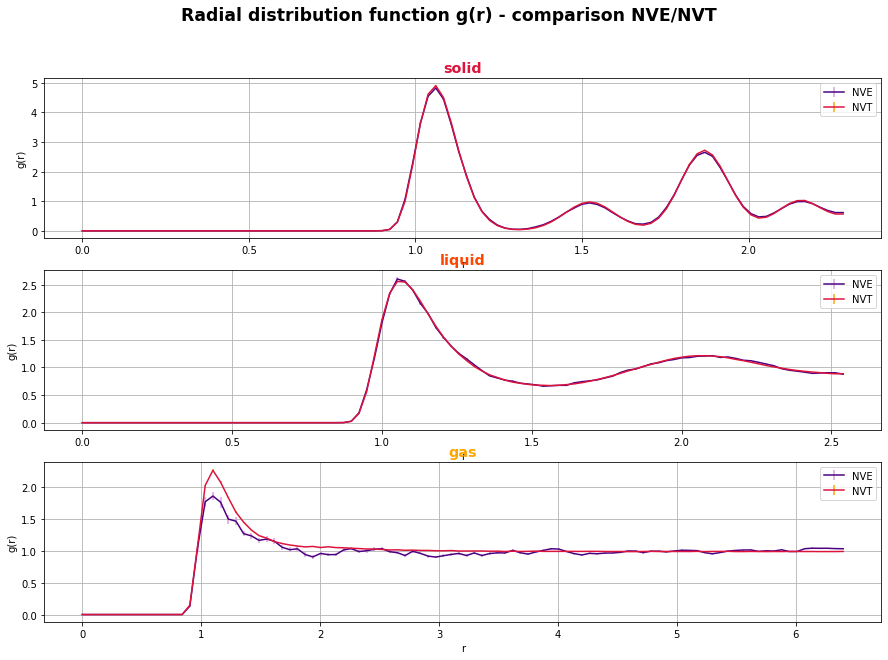

In [10]:
################## RDF g(r) - comparison ###############################################
fig=plt.figure(figsize=(15, 10))
plt.suptitle("Radial distribution function g(r) - comparison NVE/NVT", size='xx-large', weight='bold')

for i in range(3):
    plt.subplot(3,1,i+1)
    x,y,err = np.loadtxt(phases[i]+"/output.gave.0", usecols=(1,3,4),unpack=True)
    xE,yE,errE=np.loadtxt("NVE/"+phases[i]+"/ave_gave.out", usecols=(1,2,3),unpack=True)
    plt.errorbar(xE,yE,yerr=errE, color='indigo', ecolor='plum', label='NVE')
    plt.errorbar(x,y,yerr=err, color='crimson', ecolor='orange', label='NVT')
        
    plt.xlabel('r')
    plt.ylabel('g(r)')
    #plt.xlim(0,6)
    plt.title(phases[i], color=colorsg[i], size='x-large', weight='bold')
    plt.grid(True)
    plt.legend()

plt.show()

We can see an excellent match between the curves generated from the two different codes (expect for little difference of the gas phase around the maximum value of $g(r)$, probably due to intrinsic difficulty in evaluating results from the gas phase).

## <span style="color:navy">7.4) Real experiments: Argon, Kripton</span>

In the last exercise we are asked to evaluate the results in the real cases of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) and Krypton ($\sigma = 0.364$ nm, $\epsilon/k_B = 164$ K, $m=83.798$ amu) in all three phases using the NVT code and to compare the outputs for the the radial distribution function between NVE and NVT code.

In contrast with what I did in Exercise 4, I now decide to use the same C++ code of previous exercises (in LJ units and input file= <font face="Courier">input.dat</font>), but managing input-output files and converting results in SI systems via the following Python script.

**Note:** In order to show the behaviour of the $g(r)$ mean for increasing number of blocks, I chose to plot the trend line of $g_{max}$ (i.e. peak of g(r)) as example of the overall trend.

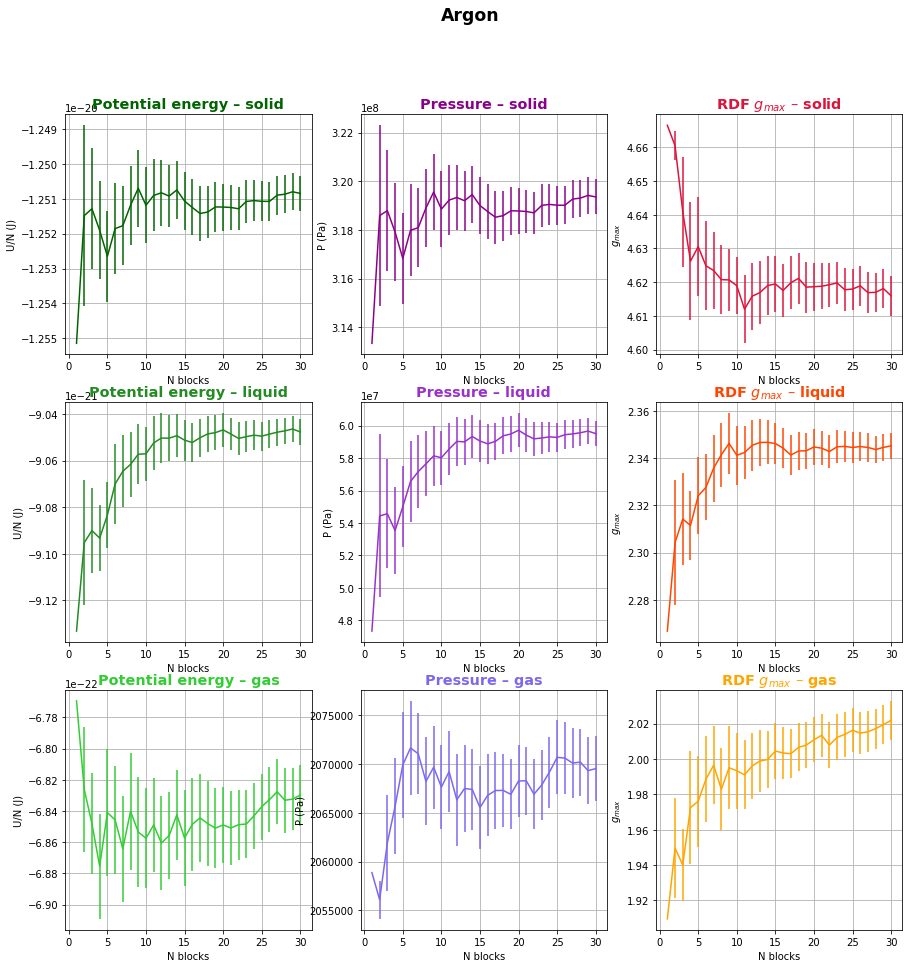

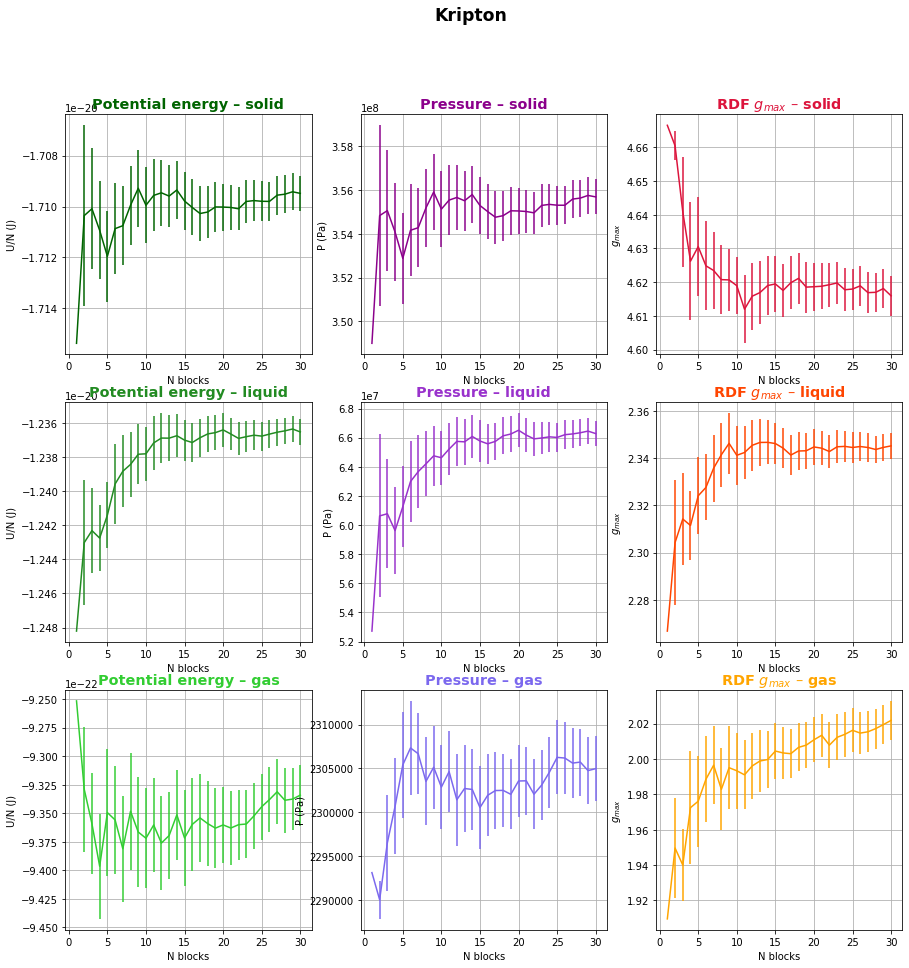

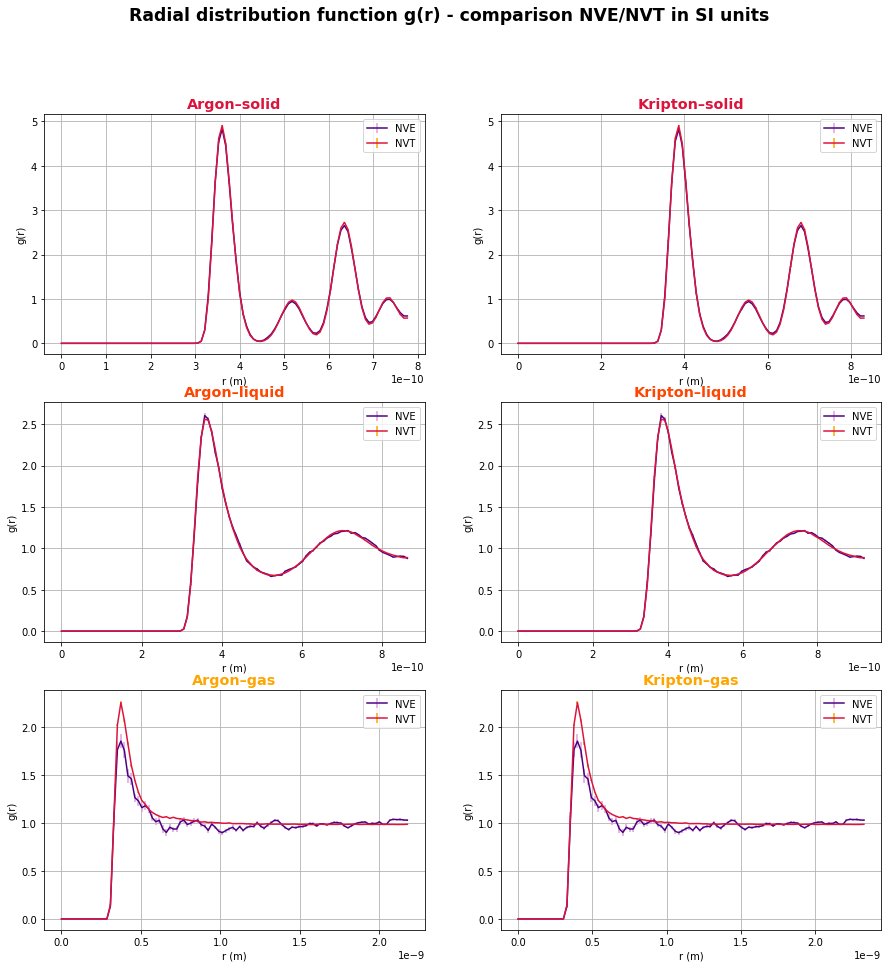

In [11]:
####################### REAL EXPERIMENTS #############################################
elements=['Argon', 'Kripton']

#parameters for SI
kb=1.38064852E-23
amu=1.66054E-24
nm=1.0E-9

sigma=[0.34*nm,0.364*nm]
epsilon_kb=[120,164]
mass=[39.948*amu,83.798*amu]
epsilon=[120*kb,164*kb]

fp=[]
for e in range(2):
    fp.append(epsilon[e]/sigma[e]/sigma[e]/sigma[e])

#phases=['solid','liquid','gas']
colors2=['darkgreen', 'forestgreen', 'limegreen', 'darkmagenta', 'darkorchid', 'mediumslateblue','crimson', 'orangered','orange']
titles2=['Potential energy', 'Pressure','RDF $g_{max}$']
axis2=['U/N (J)', 'P (Pa)', '$g_{max}$']
output2=['epot','pres', 'gofr']

#plot data
for e in range(2): #cycle over element
    fig=plt.figure(figsize=(15, 15))
    plt.suptitle(elements[e], size='xx-large', weight='bold')

#–––––––––––––––––––––––––––––––––––––––
    #1)Potential energy
    #2)Pressure
    for a in range(2): #cyclew over observables
        for i in range(3): #cycle over phase
            plt.subplot(3,3,a+i*3+1)
            x, y, err = np.loadtxt(phases[i]+"/output."+output[a]+".0", usecols=(0,2,3),unpack=True)
            if (a==0):
                conv=epsilon[e]
            elif (a==1):
                conv=fp[e]
            y*=conv
            err*=conv
            plt.errorbar(x,y,yerr=err, color=colors2[i+a*3], label='NVT')

            plt.ylabel(axis2[a])
            plt.xlabel('N blocks')
            plt.title(titles2[a]+" – "+phases[i], color=colors2[i+a*3], size='x-large', weight='bold')
            plt.grid(True)
#–––––––––––––––––––––––––––––––––––––––       
    a=2 #--> Rdf g(r) --> show only behaviour of g_max
    nbin=100

    for i in range(3):
        plt.subplot(3,3,a+i*3+1)
        
        #to find maximum to plot g_max
        appo=np.loadtxt(phases[i]+"/output.gofr.0", usecols=(3), unpack=True)
        nblock_appo=int(appo.size/nbin)
        skip=appo.size-nbin
        appo=np.loadtxt(phases[i]+"/output.gofr.0", usecols=(3), skiprows=skip,unpack=True)
        g_max=max(appo)
        index_max= [k for k, j in enumerate(appo) if j == g_max]
        index_max=index_max[0]
        
        #create array/list for plotting g_max in function of N blocks
        x=[]
        y=[]
        err=[]
        for n in range(nblock_appo):
            xt,yt,errt=np.loadtxt(phases[i]+"//output.gofr.0", usecols=(0,3,4), skiprows=index_max+n*nbin-1, max_rows=1, unpack=True)
            x.append(int(xt))
            y.append(yt)
            err.append(errt)
        plt.errorbar(x,y,yerr=err, color=colors2[i+a*3], label='NVT')
        plt.ylabel(axis2[a])
        plt.xlabel('N blocks')
        plt.title(titles2[a]+" – "+phases[i], color=colors2[i+a*3], size='x-large', weight='bold')
        plt.grid(True)

    plt.show()
    
################## RDF g(r) - comparison ###############################################
fig=plt.figure(figsize=(15, 15))
plt.suptitle("Radial distribution function g(r) - comparison NVE/NVT in SI units", size='xx-large', weight='bold')

for e in range(2):
    for i in range(3):
        plt.subplot(3,2,e+i*2+1)
        x,y,err = np.loadtxt(phases[i]+"/output.gave.0", usecols=(1,3,4),unpack=True)
        xE,yE,errE=np.loadtxt("NVE/"+phases[i]+"/ave_gave.out", usecols=(1,2,3),unpack=True)
        x*=sigma[e]
        xE*=sigma[e]
        plt.errorbar(xE,yE,yerr=errE, color='indigo', ecolor='plum', label='NVE')
        plt.errorbar(x,y,yerr=err, color='crimson', ecolor='orange', label='NVT')

        plt.xlabel('r (m)')
        plt.ylabel('g(r)')
        #plt.xlim(0,3)
        plt.title(elements[e]+"–"+phases[i], color=colorsg[i], size='x-large', weight='bold')
        plt.grid(True)
        plt.legend()

plt.show()